<a href="https://colab.research.google.com/github/yuliiabosher/Adam_Smith_project/blob/main/Visualisations.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install nltk
!pip install nxviz

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 332.3/332.3 kB 4.2 MB/s eta 0:00:00


In [26]:
import pandas as pd
import matplotlib.pyplot as plt
import nltk
import collections
from gensim.corpora.dictionary import Dictionary
from gensim.models.tfidfmodel import TfidfModel
import itertools
from textblob import TextBlob
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from sklearn.feature_extraction.text import CountVectorizer, ENGLISH_STOP_WORDS
import networkx as nx
import nxviz as nv
from nxviz import annotate
import seaborn as sns
import numpy as np
from PIL import Image
import warnings
warnings.filterwarnings("ignore")

nltk.download("punkt")
nltk.download("averaged_perceptron_tagger")
nltk.download('maxent_ne_chunker')
nltk.download('words')
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package maxent_ne_chunker to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package maxent_ne_chunker is already up-to-date!
[nltk_data] Downloading package words to /root/nltk_data...
[nltk_data]   Package words is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [3]:
def month_to_number(month):
  months = {"january": "1", "february": "2", "march": "3", "april": "4", "may": "5", "june": "6", "july": "7", \
            "august": "8", "september": "9", "october": "10", "november": "11", "december": "12"}
  month = month.lower()
  numerical = months[month]
  return numerical

def to_date(string):
  elements = string.split(',')
  year = elements[-1].strip()
  month, day = elements[-2].split()
  month = month_to_number(month)
  date = f'{year}-{month}-{day}'
  return date

In [4]:
def clean_df(df):
  df = pd.read_excel(df)
  df = df.fillna('n/a')
  df = df.drop(df[df['Mention of Adam smith'].str.contains('NA')].index)
  df = df.drop(df[df['Mention of Adam smith'].str.contains('n/a')].index)
  df.columns = ['Date', 'Extract', 'Notes', 'Notes2', 'About Adam Smith', 'Rep']
  dates = []
  for index, row in df.iterrows():
    dates.append(to_date(row['Date']))
  df['Date'] = dates
  df['Date'] = pd.to_datetime(df['Date'])
  df = df.set_index('Date').sort_index()
  return df
df = clean_df('https://github.com/yuliiabosher/Adam_Smith_project/raw/main/adam_smith.xlsx')
display(df.head())

,Extract,Notes,Notes2,About Adam Smith,Rep
Date,,,,,
1995-05-23,"As everybody knows, a little earlier this year...",n/a,n/a,n/a,Peter Anthony DeFazio\nDemocratic Party
1996-05-23,"Mr. GENE GREEN of Texas. Mr. Speaker, to my co...",n/a,n/a,n/a,Raymond Eugene “Gene” Green\n Democratic Party
1996-05-23,"When wages fall, buying power drops, and all t...",n/a,n/a,n/a,Ronald Paul Klink\nDemocratic Party
1999-10-13,These arguments are no truer today than they w...,n/a,n/a,n/a,Paul David Wellstone\nDemocratic Party
1999-10-27,Go right back to Alexander Hamilton in the ear...,n/a,n/a,n/a,Ernest Frederick “Fritz” Hollings\nDemocratic ...


In [5]:
def create_dates_list(df):
  return df.index
create_dates_list(df)

DatetimeIndex(['1995-05-23', '1996-05-23', '1996-05-23', '1999-10-13',
               '1999-10-27', '1999-10-28', '1999-11-01', '1999-11-02',
               '1999-11-09', '1999-11-09',
               ...
               '2019-03-07', '2019-12-10', '2020-10-01', '2020-12-21',
               '2021-03-19', '2021-10-06', '2021-10-07', '2022-07-19',
               '2022-07-26', '2023-03-09'],
              dtype='datetime64[ns]', name='Date', length=107, freq=None)

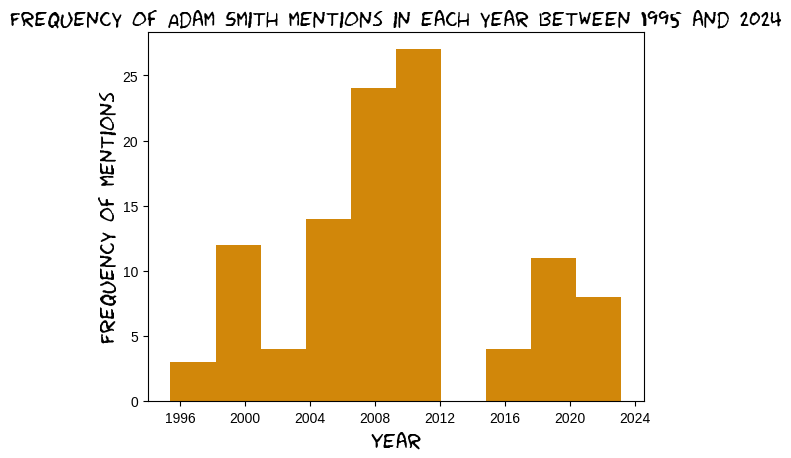

In [6]:
def create_histogram(df):
  #styles 'fast','fivethirtyeight'',',''seaborn-v0_8-whitegrid'
  fig, ax = plt.subplots()
  plt.style.use('seaborn-v0_8-whitegrid')
  plt.hist(df.index, color='#D1870A')
  font = {'family':'fantasy','color':'black','size':15}
  plt.xlabel('Year', fontdict = font)
  plt.ylabel('Frequency of mentions', fontdict = font)
  plt.title('Frequency of Adam Smith mentions in each year between 1995 and 2024', fontdict = font)
  plt.show()

create_histogram(df)

In [7]:
def tokenize_df(df):
  tokens = [nltk.word_tokenize(row['Extract']) for index, row in df.iterrows()]
  return tokens

token_list = tokenize_df(df)
print(token_list[0][:10])

['As', 'everybody', 'knows', ',', 'a', 'little', 'earlier', 'this', 'year', ',']


In [8]:
def preprocess_tokens(list_of_lists):
  lower_tokens = [[t.lower()for t in nested_list] for nested_list in list_of_lists]
  alpha_num_only = [[t for t in token_list if t.isalnum()] for token_list in lower_tokens]
  stopwords = nltk.corpus.stopwords.words('english')
  #stopwords.extend(['adam', 'smith'])
  no_stops = [[t for t in alpha_list if t not in stopwords] for alpha_list in alpha_num_only]
  wordnet_lemmatizer = nltk.stem.WordNetLemmatizer()
  lemmatized = [[wordnet_lemmatizer.lemmatize(t) for t in no_stops_list] for no_stops_list in no_stops]
  return lemmatized
preprocessed = preprocess_tokens(token_list)
print(preprocessed[0][:10])

['everybody', 'know', 'little', 'earlier', 'year', 'part', 'record', 'trade', 'deficit', 'led']


In [9]:
def create_corpus(preprocessed_data):
  dictionary = Dictionary(preprocessed)
  corpus = [dictionary.doc2bow(article) for article in preprocessed]
  return dictionary, corpus

dictionary, corpus = create_corpus(preprocessed)
print(corpus[0][:10])

[(0, 1), (1, 1), (2, 2), (3, 1), (4, 2), (5, 1), (6, 1), (7, 1), (8, 1), (9, 1)]


In [10]:
def find_most_frequently_occuring_pairs(corpus):
  word_id_list_of_lists = [[i[0] for i in j] for j in corpus]
  pair_list_of_lists = [list(itertools.combinations(nested_list,2)) for nested_list in word_id_list_of_lists]
  catalogue_of_occurences = collections.defaultdict(int)
  for list_of_pairs in pair_list_of_lists:
    for pair in list_of_pairs:
      catalogue_of_occurences[pair]+=1
  most_frequently_occuring_pairs = sorted(list(catalogue_of_occurences.items()), key=lambda x: x[1], reverse=True)
  return most_frequently_occuring_pairs
most_frequently_occuring_pairs = find_most_frequently_occuring_pairs(corpus)
print(most_frequently_occuring_pairs[:10])

[((2, 52), 104), ((2, 139), 35), ((2, 128), 34), ((52, 128), 34), ((52, 139), 34), ((2, 335), 34), ((52, 335), 34), ((2, 340), 31), ((52, 340), 31), ((2, 110), 25)]


In [11]:
for nested_tuple in most_frequently_occuring_pairs[:10]:
  print(dictionary.get(nested_tuple[0][0]), dictionary.get(nested_tuple[0][1]))

adam smith
adam market
adam free
smith free
smith market
adam nation
smith nation
adam wealth
smith wealth
adam would


In [12]:
def word_count_desc(corpus):
  total_word_count = collections.defaultdict(int)
  for word_id, word_count in itertools.chain.from_iterable(corpus):
      total_word_count[word_id] += word_count
  sorted_word_count = sorted(total_word_count.items(), key=lambda w: w[1], reverse=True)
  return sorted_word_count

sorted_word_count = word_count_desc(corpus)
print(sorted_word_count[:10])

[(2, 125), (52, 125), (139, 60), (128, 50), (335, 38), (340, 36), (98, 27), (110, 27), (57, 26), (322, 24)]


In [13]:
for word_id, word_count in sorted_word_count[:20]:
    print(dictionary.get(word_id), word_count)

adam 125
smith 125
market 60
free 50
nation 38
wealth 36
government 27
would 27
trade 26
people 24
country 22
year 22
capitalism 22
hand 20
one 20
produce 19
world 18
u 18
invisible 18
going 18


In [14]:
def calculate_weight_of_words(corpus):
  try:
    tfidf = TfidfModel(corpus)
    all_tfidf_weights = []
    i=0
    while tfidf[corpus[i]]:
      tfidf_weights = tfidf[corpus[i]]
      all_tfidf_weights.append(tfidf_weights)
      i+=1
    return all_tfidf_weights
  except IndexError:
    return all_tfidf_weights

all_tfidf_weights = calculate_weight_of_words(corpus)
for term_id, weight in all_tfidf_weights[1][:20]:
  print(dictionary.get(term_id), weight)

smith 0.0014714478375009725
world 0.09518617314092584
addams 0.24178351226913866
california 0.205918393778332
colleague 0.14109739534379329
family 0.1849386443772891
gene 0.24178351226913866
gentleman 0.205918393778332
green 0.24178351226913866
hhhhhhh 0.24178351226913866
increase 0.14907352588648243
like 0.12264216752806366
million 0.205918393778332
minimum 0.24178351226913866
news 0.205918393778332
passed 0.24178351226913866
pay 0.1849386443772891
quote 0.1849386443772891
report 0.24178351226913866
see 0.12809377648543954


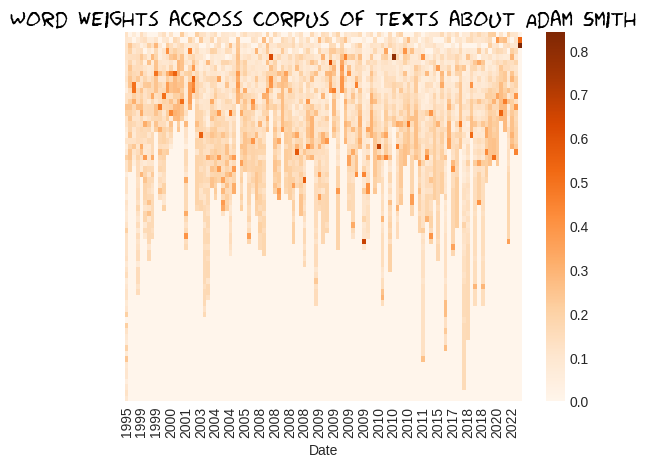

In [52]:
def build_heatmap_of_weights(all_tfidf_weights):
  weights_df = pd.DataFrame(all_tfidf_weights)
  for index, row in weights_df.iterrows():
    for i in range(len(row)):
      if row[i]:
        row[i] = row[i][1]
  weights_df = weights_df.fillna(0)
  weights_df.index = create_dates_list(df).year
  weights_df = weights_df.transpose()
  sns.heatmap(weights_df, cmap='Oranges')
  font = {'family':'fantasy','color':'black','size':15}
  plt.yticks([])
  plt.title('Word weights across corpus of texts about Adam Smith', fontdict = font)
  plt.show()
build_heatmap_of_weights(all_tfidf_weights)

In [16]:
def add_extract_length(df):
  df['Extract length'] = df['Extract'].str.len()
  return df
df = add_extract_length(df)
display(df.head())

,Extract,Notes,Notes2,About Adam Smith,Rep,Extract length
Date,,,,,,
1995-05-23,"As everybody knows, a little earlier this year...",n/a,n/a,n/a,Peter Anthony DeFazio\nDemocratic Party,847
1996-05-23,"Mr. GENE GREEN of Texas. Mr. Speaker, to my co...",n/a,n/a,n/a,Raymond Eugene “Gene” Green\n Democratic Party,277
1996-05-23,"When wages fall, buying power drops, and all t...",n/a,n/a,n/a,Ronald Paul Klink\nDemocratic Party,310
1999-10-13,These arguments are no truer today than they w...,n/a,n/a,n/a,Paul David Wellstone\nDemocratic Party,748
1999-10-27,Go right back to Alexander Hamilton in the ear...,n/a,n/a,n/a,Ernest Frederick “Fritz” Hollings\nDemocratic ...,464


In [17]:
def check_sentiment(df):
  polarity = []
  subjectivity = []
  for index, row in df.iterrows():
    sentiment = TextBlob(row['Extract'])
    polarity.append(sentiment.polarity)
    subjectivity.append(sentiment.subjectivity)
  df['Polarity'] = polarity
  df['Subjectivity'] = subjectivity
  return df

df_sentiments = check_sentiment(df)
display(df_sentiments.head())

,Extract,Notes,Notes2,About Adam Smith,Rep,Extract length,Polarity,Subjectivity
Date,,,,,,,,
1995-05-23,"As everybody knows, a little earlier this year...",n/a,n/a,n/a,Peter Anthony DeFazio\nDemocratic Party,847,0.034375,0.404167
1996-05-23,"Mr. GENE GREEN of Texas. Mr. Speaker, to my co...",n/a,n/a,n/a,Raymond Eugene “Gene” Green\n Democratic Party,277,0.166667,0.400000
1996-05-23,"When wages fall, buying power drops, and all t...",n/a,n/a,n/a,Ronald Paul Klink\nDemocratic Party,310,0.383333,0.391667
1999-10-13,These arguments are no truer today than they w...,n/a,n/a,n/a,Paul David Wellstone\nDemocratic Party,748,0.055417,0.514167
1999-10-27,Go right back to Alexander Hamilton in the ear...,n/a,n/a,n/a,Ernest Frederick “Fritz” Hollings\nDemocratic ...,464,0.183036,0.222619


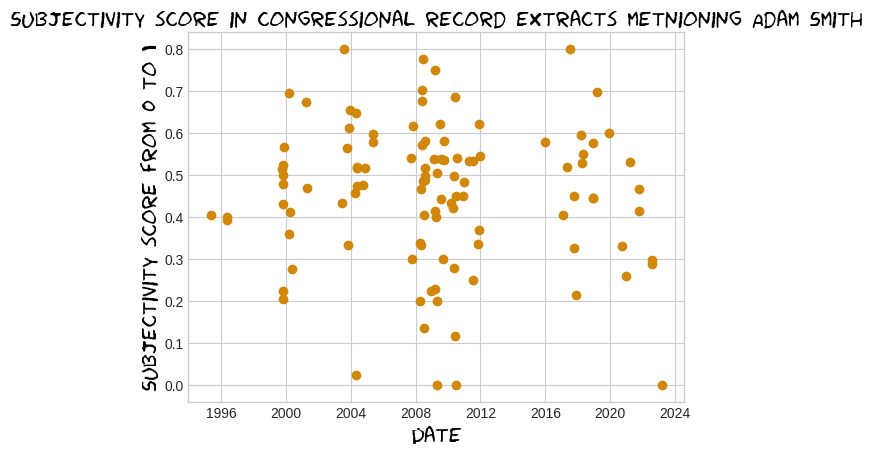

In [18]:
def plot_subjectivity_score(df):
  plt.scatter(df.index, df['Subjectivity'], color='#D1870A')
  font = {'family':'fantasy','color':'black','size':15}
  plt.ylabel('Subjectivity score from 0 to 1', fontdict = font)
  plt.xlabel('Date', fontdict = font)
  plt.title('Subjectivity score in congressional record extracts metnioning Adam Smith', fontdict = font)
  plt.show()
plot_subjectivity_score(df_sentiments)

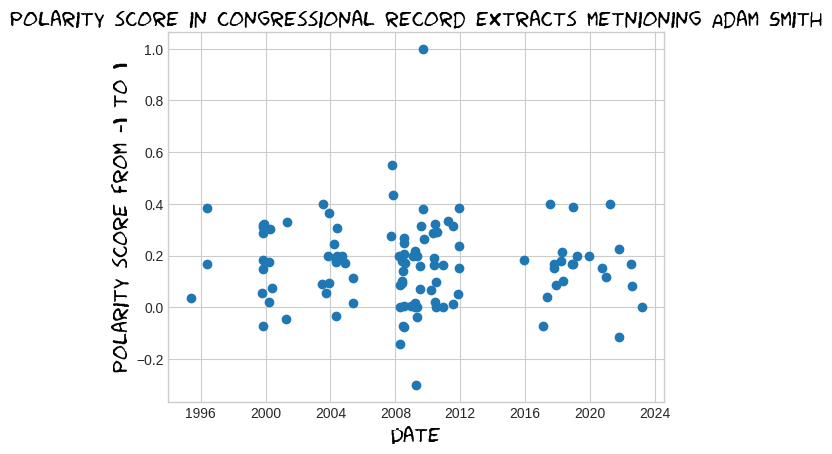

In [19]:
def plot_polarity_score(df):
  plt.scatter(df.index, df['Polarity'])
  font = {'family':'fantasy','color':'black','size':15}
  plt.ylabel('Polarity score from -1 to 1', fontdict = font)
  plt.xlabel('Date', fontdict = font)
  plt.title('Polarity score in congressional record extracts metnioning Adam Smith', fontdict = font)
  plt.show()
plot_polarity_score(df_sentiments)

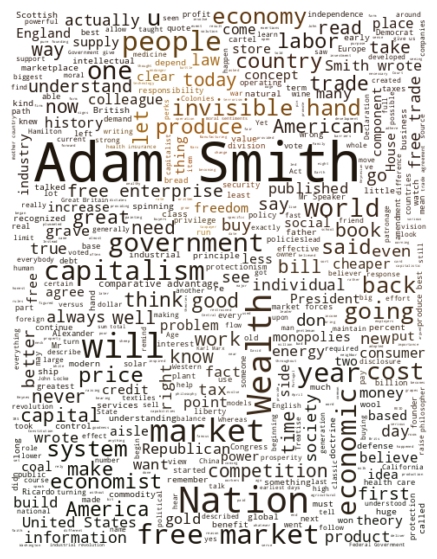

In [38]:
def word_cloud(df):
  stopwords = set(STOPWORDS)
  stopwords.update(['s', 't'])
  mask = np.array(Image.open("/content/adam-smith.jpg"))
  image_colors = ImageColorGenerator(mask)
  plt.figure(figsize=[7,7])
  text = ""
  for index, row in df.iterrows():
    text += " "
    text += row['Extract']
  word_cloud = WordCloud(stopwords=stopwords, background_color="white", max_words=500, mask=mask).generate(text)
  plt.imshow(word_cloud.recolor(color_func=image_colors), interpolation='bilinear')
  plt.axis('off')
  plt.show()
word_cloud(df)

In [21]:
def bow_with_ngrams(df):
  my_stop_words = list(ENGLISH_STOP_WORDS.union(['adam', 'smith', 'speaker', 'don', 'seen', 'smith' 'wrote', 'actually', 'mr speaker', 'sure', 'said']))
  vect = CountVectorizer(ngram_range=(1, 2), max_features=200, stop_words=my_stop_words)
  vect.fit(df.Extract)
  X_extract = vect.transform(df.Extract)
  X_df=pd.DataFrame(X_extract.toarray(), columns=vect.get_feature_names_out())
  return X_df
display(bow_with_ngrams(df).columns)
bow_bigrams = bow_with_ngrams(df).head()
print(bow_bigrams)

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:409: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['mr'] not in stop_words.
  warnings.warn(


Index(['1776', 'advantage', 'agree', 'aisle', 'amendment', 'america',
       'american', 'americans', 'base', 'based',
       ...
       'went', 'won', 'wool', 'work', 'works', 'world', 'wrote', 'year',
       'year 1776', 'years'],
      dtype='object', length=200)

   1776  advantage  agree  aisle  amendment  america  american  americans  \
0     0          0      0      0          0        2         0          0   
1     0          0      0      0          0        0         0          0   
2     0          0      0      0          0        0         0          0   
3     0          0      0      0          0        0         0          0   
4     0          2      0      0          0        0         0          0   

   base  based  ...  went  won  wool  work  works  world  wrote  year  \
0     0      0  ...     0    0     0     0      0      2      0     1   
1     0      0  ...     0    0     0     0      0      1      0     0   
2     0      0  ...     0    0     0     0      0      0      0     0   
3     0      0  ...     0    0     0     0      0      0      0     0   
4     0      0  ...     0    1     0     0      0      0      0     0   

   year 1776  years  
0          0      1  
1          0      0  
2          0      0  
3         

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:409: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['mr'] not in stop_words.
  warnings.warn(
